## Imports

In [45]:
df.shape

(379014, 10)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import category_encoders as ce
import plotly.graph_objs as go

import shap

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline

from xgboost import XGBRFClassifier, XGBRFRegressor, XGBClassifier

import eli5
from eli5.sklearn import PermutationImportance

from pdpbox.pdp import pdp_isolate, pdp_plot

from scipy.stats import boxcox
from scipy.special import inv_boxcox

import pprint
pp = pprint.PrettyPrinter(indent=4)

# Data Loading

In [2]:
odf = pd.read_csv('data/openpowerlifting.csv', low_memory=False)
odf.columns = [s.lower() for s in odf.columns.tolist()]

keep = [
 'sex',
 'age',
 'bodyweightkg',
 'best3squatkg',
 'best3benchkg',
 'best3deadliftkg',
 'totalkg'
 ]
 
df = odf[keep].dropna()

# Data Processing

In [3]:
convert = [
 'bodyweightkg',
 'best3squatkg',
 'best3benchkg',
 'best3deadliftkg',
 'totalkg'
 ]
converted = [
 'body_weight',
 'squat',
 'bench',
 'deadlift',
 'total'
 ]

# convert to lbs, absolute negative entries, to int, rename n drop old names
df[converted] = abs(df[convert]*2.2042).astype(int)
df = df.drop(convert, axis=1)

# adjust total given some entries were recorded as negatives
df['total']= df['squat']+df['bench']+df['deadlift']

# Feature Engineering

In [4]:
lifts = ['squat','bench','deadlift']
# add features of normalized lifts by total
for lift in lifts:
    df[lift+'_norm'] = df[lift]/df['total']

### Cleaning

In [5]:
# remove too old and too young and unrealistic totals
df = df[(df['age']>16)&(df['age']<60)&(df['total']>250)].drop_duplicates()

#remove men that are fresh lifters
df = df[~((df['sex']=='M')&(df['bench']<120))]

#remove normalized outliers to remove, specfically, recording errors
def remove_outliers(dataframe, feature, percent):
    condition = ((dataframe[feature] > dataframe[feature].quantile(percent))&
                (dataframe[feature] < dataframe[feature].quantile(1-percent)))
    return dataframe[condition]

men = df[df['sex']=='M']
women = df[df['sex']=='F']

for key, value in {'bench_norm':0.01,'squat_norm':0.01,'deadlift_norm':0.01}.items():
    men = remove_outliers(men, key, value)
    women = remove_outliers(women, key, value)

df = pd.concat([men, women])

# Men vs Women Lifting Graph

In [6]:
grapable_df = df.sample(10_000)
men = grapable_df[grapable_df['sex']=='M']
women = grapable_df[grapable_df['sex']=='F']

men_scatter = go.Scatter3d(x=men.squat, 
                     y=men.bench, 
                     z=men.deadlift,
                     mode='markers',
                     marker=dict(size=3,
                                line=dict(width=1),
                                color="blue"),
                     text=men.sex)
                     
women_scatter = go.Scatter3d(x=women.squat, 
                     y=women.bench, 
                     z=women.deadlift,
                     mode='markers',
                     marker=dict(size=3,
                                line=dict(width=1),
                                color="red"),
                     text=women.sex)

data_comp = [men_scatter, women_scatter]
fig = go.Figure(data_comp)
fig.show()

# Baseline

In [7]:
df.sex.value_counts(normalize=True)

M    0.711889
F    0.288111
Name: sex, dtype: float64

# Model Building

In [8]:
target = 'sex'
features = [ f for f in df.columns.tolist() if f !=target]
build, holdout, build_labels, holdout_labels = train_test_split(df[features],
                                                                df[target], 
                                                                test_size=0.10,
                                                                random_state=42,
                                                                stratify=df[target])

train, test, train_labels, test_labels = train_test_split(build,
                                                            build_labels, 
                                                            test_size=0.20,
                                                            random_state=42,
                                                            stratify=build_labels)

eval_set = [(train, train_labels), (test, test_labels)]

XGBclf = XGBClassifier(n_jobs=-1, n_estimators=1000, monotone_constraints = (0,1,1,1,1,1,0,0,0), random_state=42, objective = 'binary:logistic')

param_grid = {
        'max_features': ['sqrt'],
        'max_depth': [5],
        'min_samples_split': [2],
        'min_samples_leaf': [1],
        'min_child_weight':[1],
        'learning_rate':[0.1],
        }

clf = GridSearchCV(estimator=XGBclf, verbose=10, param_grid=param_grid, cv=2)

clf.fit(train, train_labels.values.flatten(), eval_set=eval_set, eval_metric='logloss', early_stopping_rounds=50, verbose=0)

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] learning_rate=0.1, max_depth=5, max_features=sqrt, min_child_weight=1, min_samples_leaf=1, min_samples_split=2
[CV]  learning_rate=0.1, max_depth=5, max_features=sqrt, min_child_weight=1, min_samples_leaf=1, min_samples_split=2, score=0.948, total=  31.6s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.5s remaining:    0.0s
[CV] learning_rate=0.1, max_depth=5, max_features=sqrt, min_child_weight=1, min_samples_leaf=1, min_samples_split=2
[CV]  learning_rate=0.1, max_depth=5, max_features=sqrt, min_child_weight=1, min_samples_leaf=1, min_samples_split=2, score=0.948, total=  32.9s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None,
                                     monotone_constraints=(0, 1, 1, 1, 1, 1, 0,
                                                           0, 0),
                                     n_estimators=1000, n_jobs=-1, nthread=None,
                                     objective='binary...
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='warn', n_

In [9]:
print('Validation Accuracy: ', clf.best_score_)
print('Best Parameters: ')
pp.pprint(clf.best_params_)

Validation Accuracy:0.9478212753170703
Best Parameters:
{'learning_rate':0.1,
'max_depth':5,
'max_features':'sqrt',
'min_child_weight':1,
'min_samples_leaf':1,
'min_samples_split':2}


# Validation Curve

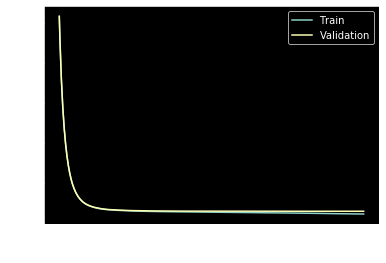

In [10]:
results = clf.best_estimator_.evals_result()
train_error = results['validation_0']['logloss']
val_error = results['validation_1']['logloss']
epoch = range(1, len(train_error)+1)

plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.legend()
plt.savefig('validation_curve.png')
plt.show()

# Prediction

In [11]:
pred = clf.predict(holdout)
pred_prob = clf.predict_proba(holdout)

In [12]:
accuracy_score(pred, holdout_labels)

0.9458076090971452


# Confusion Matrix

In [13]:
labels = unique_labels(pred)
columns = [f'Predicted {label}' for label in labels]
index = [f'Actual {label}' for label in labels]
pd.DataFrame(confusion_matrix(pred, holdout_labels), columns=columns, index=index)

,Predicted F,Predicted M
Actual F,9748,882
Actual M,1172,26100


# Permutation Importance

In [14]:
%%capture
permuter = PermutationImportance(
    clf, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

permuter.fit(train, train_labels)

print('done')

PermutationImportance(cv='prefit',
                      estimator=GridSearchCV(cv=2,
                                             error_score='raise-deprecating',
                                             estimator=XGBClassifier(base_score=0.5,
                                                                     booster='gbtree',
                                                                     colsample_bylevel=1,
                                                                     colsample_bynode=1,
                                                                     colsample_bytree=1,
                                                                     gamma=0,
                                                                     learning_rate=0.1,
                                                                     max_delta_step=0,
                                                                     max_depth=3,
                                                             

In [15]:
feature_names = train.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

bench            0.148284
deadlift         0.054687
age              0.027021
bench_norm       0.019580
squat_norm       0.018410
deadlift_norm    0.016649
body_weight      0.003495
total            0.000761
squat            0.000295
dtype: float64

# PDP

In [16]:
isolated_bench_norm = pdp_isolate(
    model=clf, 
    dataset=train, 
    model_features=train.columns,
    feature='bench', 
    num_grid_points=50
)

isolated_total = pdp_isolate(
    model=clf, 
    dataset=train, 
    model_features=train.columns,
    feature='total', 
    num_grid_points=50
)

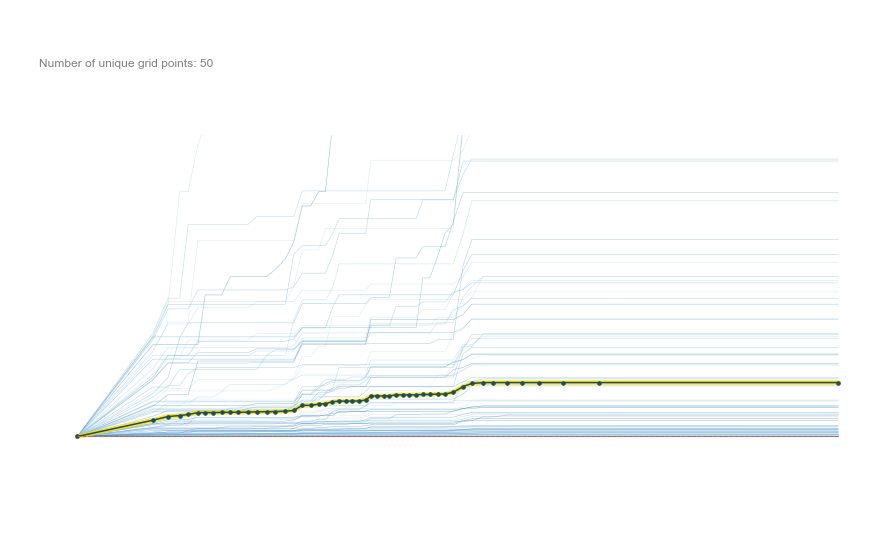

In [17]:
pdp_plot(isolated_total, feature_name='total', plot_lines=True, frac_to_plot=100)
plt.grid(color='white')
plt.tick_params(colors='white')
plt.savefig('total_pdp.png')

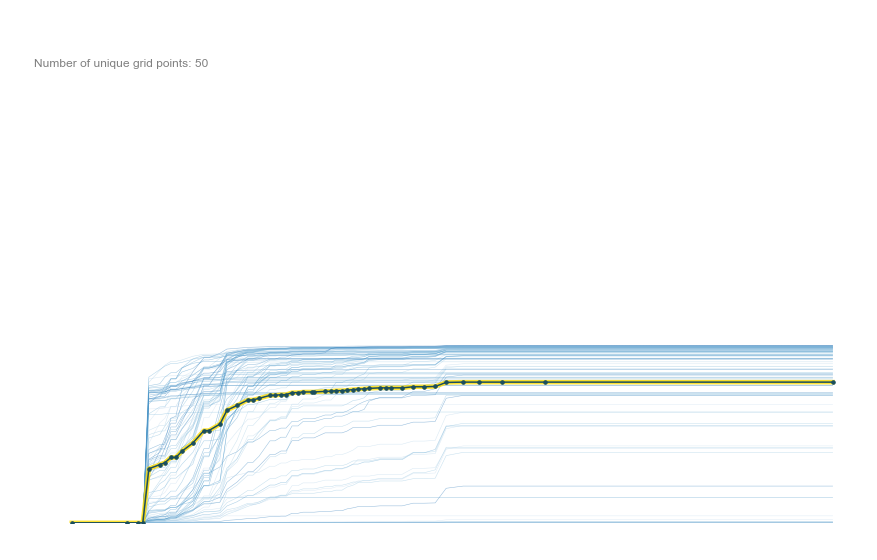

In [18]:
pdp_plot(isolated_bench_norm, feature_name='bench', plot_lines=True, frac_to_plot=100)
plt.grid(color='white')
plt.tick_params(colors='white')
plt.savefig('bench_pdp.png')

# Shaply

In [43]:
def explain(row_number):
    explainer = shap.TreeExplainer(clf.best_estimator_ )
    row = train.iloc[[row_number]]
    shap_values = explainer.shap_values(row)

    shap.initjs()
    return shap.force_plot(
                plot_cmap='BuRd',
                base_value=explainer.expected_value, 
                shap_values=shap_values, 
                features=row
            )

In [44]:
explain(10)

In [23]:
train_labels.iloc[[10]]

8273    F
Name: sex, dtype: object

In [24]:
train.iloc[[10]]

,age,body_weight,squat,bench,deadlift,total,squat_norm,bench_norm,deadlift_norm
8273,18.5,134,220,154,275,649,0.338983,0.237288,0.423729
